# FuncADL: Functional Analysis Description Language

## Motivation

- Query languages:
    - Database management systems help to address, among other issues
        - data redundancy
        - data independence
    - A key aspect of database management is query languages, such as SQL
- Functional languages:
    - Functional programming offers several desirable features for physics analyses:
        - Declarative
        - Stateless
        - Lazy
- Both of these concepts lead to more modular code:○Insulate analysis code from data storage location and file format
    - Insulate each section of code from other parts of the code

FuncADL is a functional data query language using Python as a host language, based on [LINQ](https://docs.microsoft.com/en-us/dotnet/csharp/programming-guide/concepts/linq/), a collection of features built into C#.

## Module setup

I'll use standard matplotlib to make plots:

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200 # make figures bigger and more readable

The object we need to run FuncADL locally is `UprootDataset`:

In [2]:
from func_adl_uproot import UprootDataset

This explicitly tells FuncADL that we want to use the Uproot-based backend.

## Dataset

The dataset I use here is CMS open data converted to NanoAOD format, available via xrootd. `UprootDataset` expects a file location and a tree name:

In [3]:
ds = UprootDataset('Run2012B_SingleMu_1000.root', 'Events')

Now we have a dataset ready to run FuncADL queries on.

## Writing queries

In the rest of the notebook, I'll be introducing new query operators and then showing how they apply to some [benchmark tasks](https://github.com/iris-hep/adl-benchmarks-index) that have been developed by the HEP Software Foundation and IRIS-HEP to demonstrate the core functionality of different analysis description languages.

## Some basics

The most important thing to understand is that nearly everything in FuncADL is simply treated as a sequence of elements. Arrays are sequences of rows. For example, the dataset object is just a sequence of event objects. An event object is a dictionary containing all of the properties of the event, whose values either are primitive types like `int`s or `float`s or are sequences themselves. Thus almost all FuncADL operators expect to act on a sequence.

## Select

The most common operator is `Select`. `Select` transforms each element of a sequence according to some predicate function and returns the sequence formed by all the tranformed elements. It's basically a generic `map()`.

Visually, it does this:

```
[1, 2, 3].Select(lambda x: x + 1) -> [2, 3, 4]
```

This operator is all we need for the first benchmark task.

## Task 1: Plot the <i>E</i><sub>T</sub><sup>miss</sup> of all events.

MET is in the branch `MET_pt`.

In [4]:
missing_ET_query = ds.Select(lambda event: event.MET_pt)

This didn't actually do anything yet. FuncADL uses delayed execution, so the value won't be calculated until we run `.value()`:

In [5]:
%%time

missing_ET = missing_ET_query.value()

CPU times: user 421 ms, sys: 23.1 ms, total: 444 ms
Wall time: 531 ms


Now we've actually stored the result:

In [6]:
missing_ET

<Array [22.2, 13.9, 15, ... 11.2, 22.3, 24.2] type='1000 * float32'>

And we can plot it:

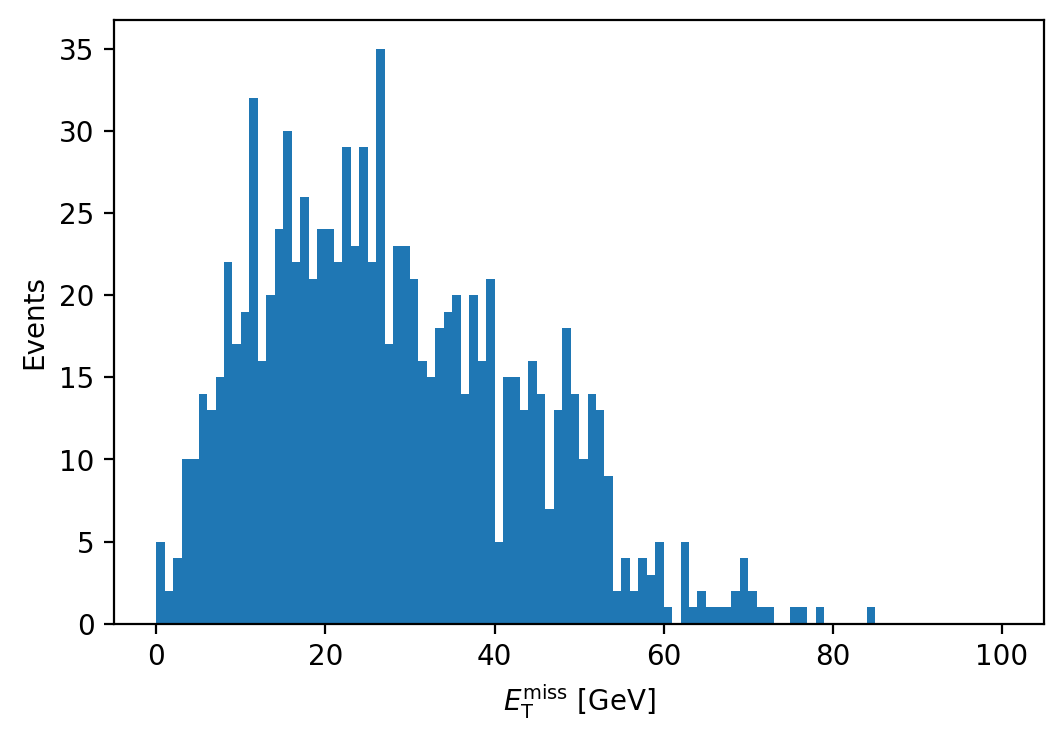

In [7]:
plt.hist([missing_ET], bins=100, range=(0, 100))
plt.xlabel(r'$E_\mathrm{T}^\mathrm{miss}$ [GeV]')
plt.ylabel('Events')
plt.show()

## SelectMany

`SelectMany` is an operator that starts by doing exactly the same thing as `Select`, but it assumes that each element in the sequence gets mapped to a sequence itself, and after performing the mapping, it concatenates all of these sequences.

Visually:

```
[1, 2, 3].SelectMany(lambda x: [x - 1, x + 1]) -> [0, 2, 1, 3, 2, 4]
```

In the intermiate step, `SelectMany` forms the sequence `[0, 2], [1, 3], [2, 4]` and then concatenates all of these together.

Often this operator is used when the elements were already sequences, so that we can just flatten an array:

```
[[1, 2], [3]].SelectMany(lambda s: s) -> [1, 2, 3]
```

`SelectMany` is the only operator needed for the second task.

## Task 2: Plot the <i>p</i><sub>T</sub> of all jets.

In [8]:
jet_pT = ds.SelectMany(lambda event: event.Jet_pt).value()

In [9]:
jet_pT

<Array [71.7, 27.8, 23.2, ... 20.9, 16.7, 15.5] type='1699 * float32'>

Note the difference between the above result and the unflattened result we'd get from just `Select`:

In [10]:
ds.Select(lambda event: event.Jet_pt).value()

<Array [[71.7, 27.8], ... 20.9, 16.7, 15.5]] type='1000 * var * float32'>

This is a sequence of sequences--a jagged array. In principle we could have used this for this particular task; we just would have needed to manually call `ak.flatten` on the array afterwards.

Now we can plot the `SelectMany` result:

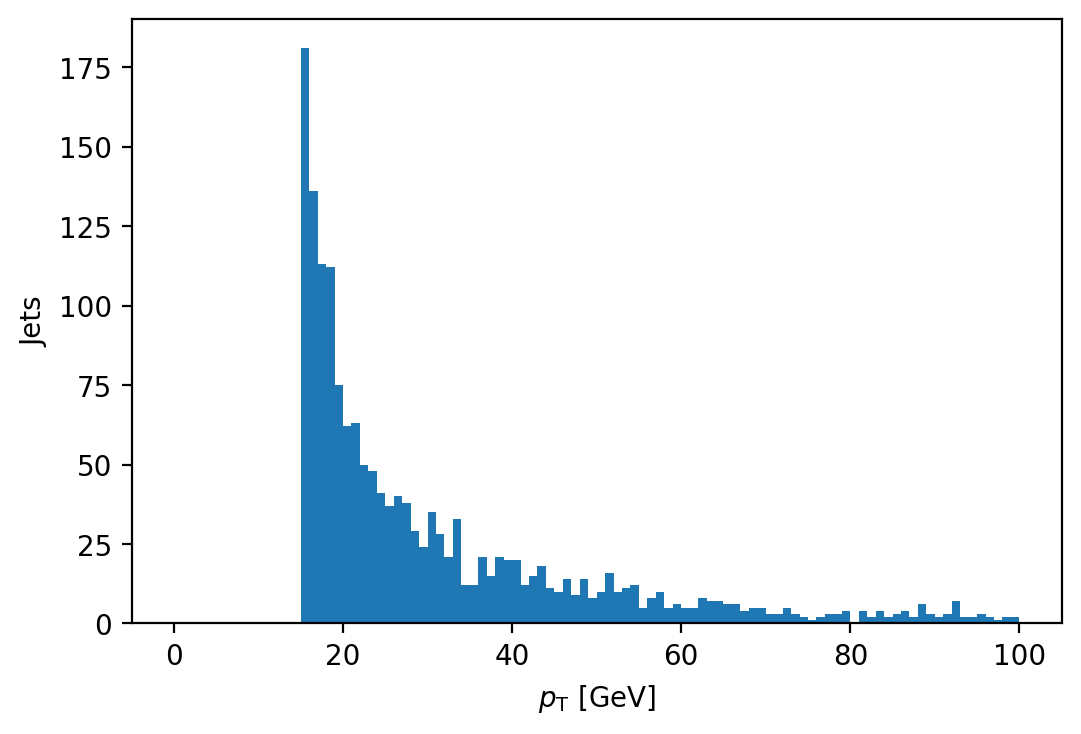

In [11]:
plt.hist([jet_pT], bins=100, range=(0, 100))
plt.xlabel(r'$p_\mathrm{T}$ [GeV]')
plt.ylabel('Jets')
plt.show()

## Where

With `Select` and `SelectMany`, we can already filter out event properties (branches) that we aren't interested in. But what if we want to filter out certain events or jets? We need to discard elements of a sequence to do this. This is done by the `Where` operator. `Where` applies a boolean-valued function to each element and discards that element if the function returned `False`.

Visually, we have:
```
[1, -2, 3].Where(lambda x: x > 0) -> [1, 3]
```

## Zip

When we start dealing with sequences within events (like jets) in more detail, we'll need to somehow wrap together multiple properties that correspond to the same physical objects. That way when we make a selection cut on jet `pT` for example, we'll be filtering the corresponding `eta`, `phi`, and `mass` values too. To do this, we use the `Zip` operator. `Zip` expects a sequence of sequences, and it will make a new sequence out of all the elements at each particular index of the sequences. In other words, it transposes the matrix formed by the input sequences.

So this looks like:
```
[[1, 3, 5], [2, 4, 6]].Zip() -> [[1, 2], [3, 4], [5, 6]]
```

But usually this is actually done with a dictionary, which is just a special type of sequence:
```
{'a': [1, 3, 5], 'b': [2, 4, 6]}.Zip() -> [{'a': 1, 'b': 2}, {'a': 3, 'b': 4}, {'a': 5, 'b': 6}]
```

In `awkward` language, this turns a record of arrays into an array of records.

The next task requires looking a jet variable other than the one used for filtering, so we can use `Zip` here.

## Task 3: Plot the <i>p</i><sub>T</sub> of jets with |<i>η</i>| < 1.

In [12]:
filtered_jet_pT = ds.SelectMany(lambda event: {'pT': event.Jet_pt, 'eta': event.Jet_eta}.Zip()
                                              .Where(lambda jet: abs(jet.eta) < 1)
                                              .Select(lambda jet: jet.pT)).value()

Note that builtin functions like `abs` are allowed in queries.

In [13]:
filtered_jet_pT

<Array [27.8, 17.4, 33.7, ... 33.9, 23.9, 23.3] type='680 * float32'>

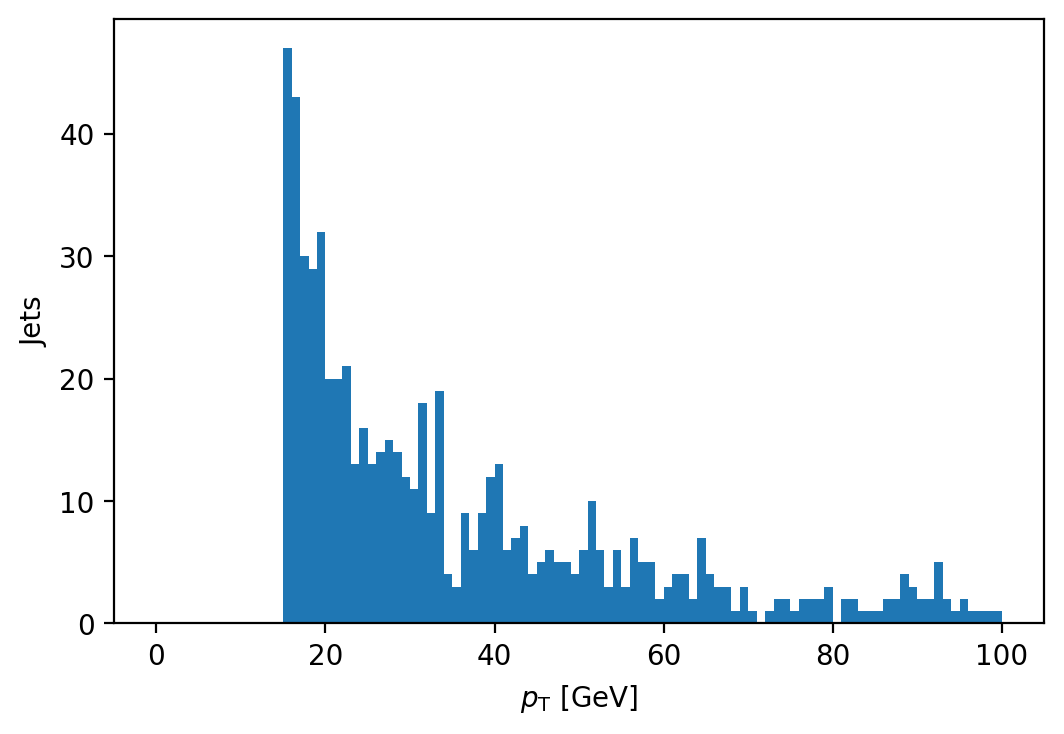

In [14]:
plt.hist([filtered_jet_pT], bins=100, range=(0, 100))
plt.xlabel(r'$p_\mathrm{T}$ [GeV]')
plt.ylabel('Jets')
plt.show()

## Count

Next we're going to need to filter based on a discrete number of objects passing some cut. `Count` is an operator that takes a sequence and just returns a scalar--the length of the sequence.

```
[0, 2, 5].Count() -> 3
```

## Task 4: Plot the <i>E</i><sub>T</sub><sup>miss</sup> of events that have at least two jets with <i>p</i><sub>T</sub> > 40 GeV.

In [15]:
filtered_missing_ET_4 = ds.Where(lambda event: event.Jet_pt.Where(lambda pT: pT > 40).Count() >= 2)\
                          .Select(lambda event: event.MET_pt).value()

In [16]:
filtered_missing_ET_4

<Array [15, 44.7, 30.5, ... 29.9, 11.5, 27.5] type='116 * float32'>

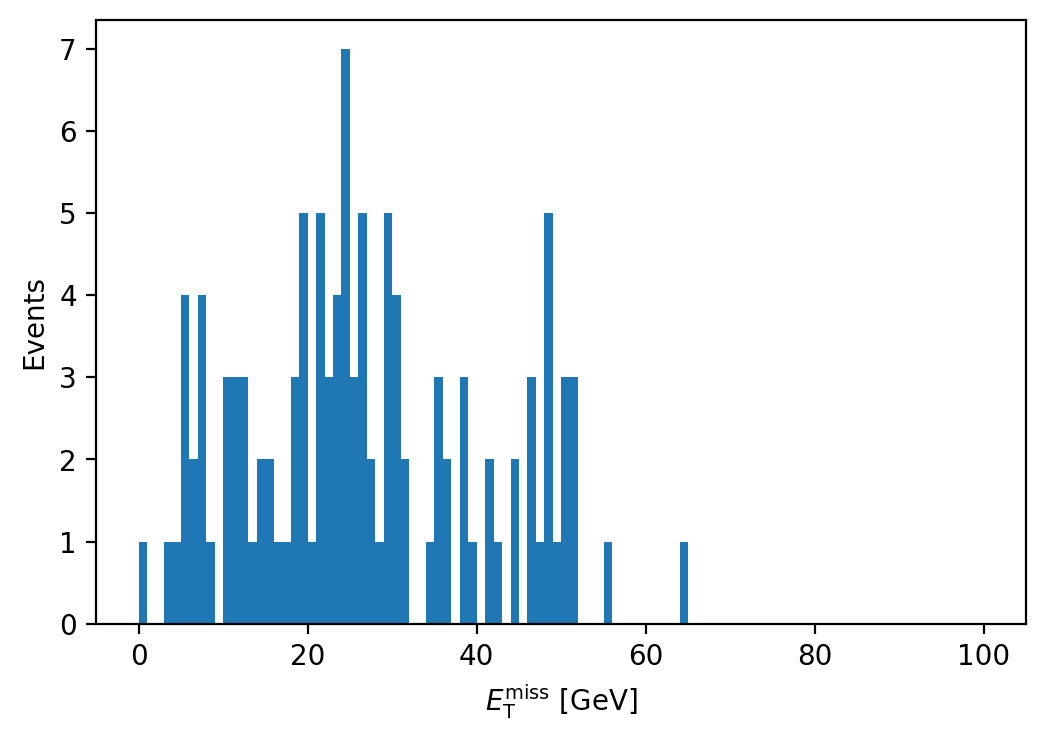

In [17]:
plt.hist([filtered_missing_ET_4], bins=100, range=(0, 100))
plt.xlabel(r'$E_\mathrm{T}^\mathrm{miss}$ [GeV]')
plt.ylabel('Events')
plt.show()

## Choose

Dealing with combinatorics is a common issue in HEP analyses. `Choose` is an operator that takes a sequence and produces all combinations of a given number of elements (think "n choose k" like $\binom{n}{k}$).

```
[1, 2, 3].Choose() -> [[1, 2], [1, 3], [2, 3]]
```

## ToFourMomenta

Dealing with four-vectors is another nearly ubiquitous aspect of HEP analysis, but ntuples usually have the components of vectors in seperate `float` branches, rather than as four-vector objects. To accomodate this in `func_adl_uproot`, I've added a `ToFourMomenta` operator that uses scikit-hep/vector to create the vector objects and perform four-vector operations within FuncADL.

```
[{'pt': pt1, 'eta': eta1, 'phi': phi1', 'mass': mass1},
 {'pt': pt2, 'eta': eta2, 'phi': phi2', 'mass': mass2},
 ...].ToFourMomenta() -> [four_vector1, four_vector2, ...]
```

## Task 5: Plot the <i>E</i><sub>T</sub><sup>miss</sup> of events that have an opposite-charge muon pair with an invariant mass between 60 and 120 GeV.

In [18]:
filtered_missing_ET_5 = ds.Where(lambda event: Zip({'p4': Zip({'pt':   event.Muon_pt,
                                                               'eta':  event.Muon_eta,
                                                               'phi':  event.Muon_phi,
                                                               'mass': event.Muon_mass}).ToFourMomenta(),
                                                    'charge': event.Muon_charge})
                                               .Choose(2)
                                               .Where(lambda pair: pair[0].charge * pair[1].charge > 0)
                                               .Select(lambda pair: (pair[0].p4 + pair[1].p4).mass)
                                               .Where(lambda mass: 60 < mass and mass < 120)
                                               .Count() > 0
                                ).Select(lambda event: event.MET_pt).value()

In [19]:
filtered_missing_ET_5

<Array [46.1, 48.3, 32, ... 44.2, 59.1, 12.1] type='7 * float32'>

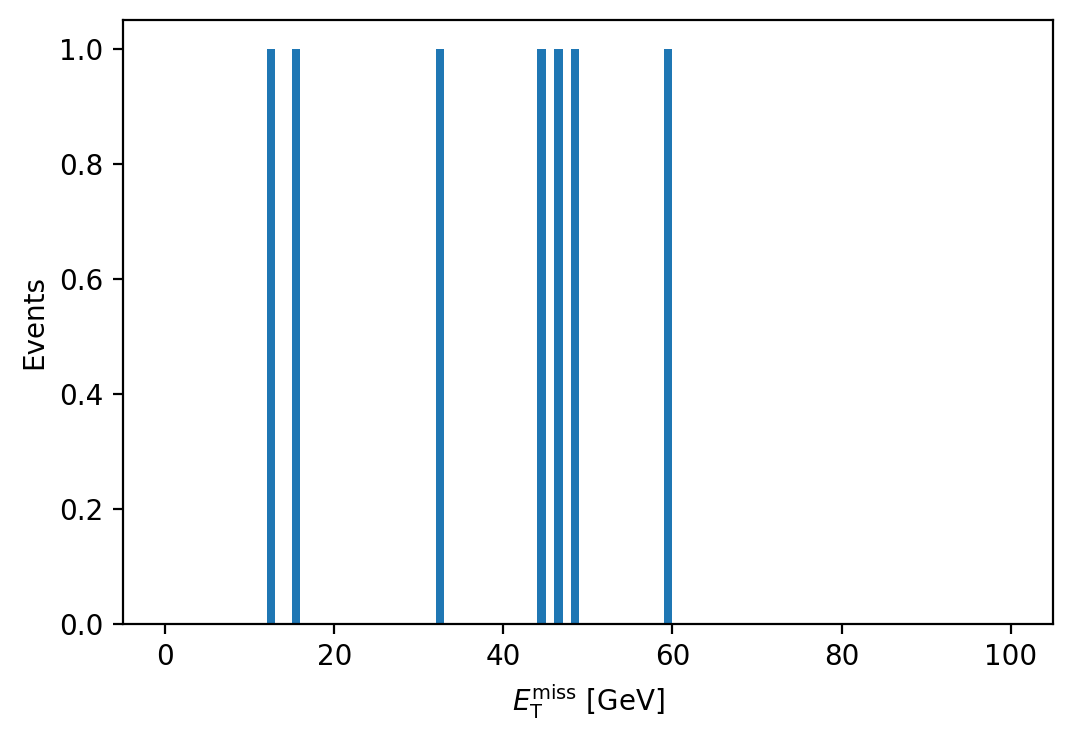

In [20]:
plt.hist([filtered_missing_ET_5], bins=100, range=(0, 100))
plt.xlabel(r'$E_\mathrm{T}^\mathrm{miss}$ [GeV]')
plt.ylabel('Events')
plt.show()

## Unfinished

Here be dragons...

For now, these last few queries won't work. They use operations that haven't been implemented in `func_adl_uproot` yet. They will be in a new version soon. I've sketched in examples that may work in the next release, but these API aspects are not final yet.

## Task 6: For events with at least three jets, plot the <i>p</i><sub>T</sub> of the trijet four-momentum that has the invariant mass closest to 172.5 GeV in each event and plot the maximum <i>b</i>-tagging discriminant value among the jets in this trijet.

In [21]:
# ds.Where(lambda event: event.nJet >= 3).Select(lambda event: [Zip({'p4': Zip({'pt': event.Jet_pt,
#                                                                               'eta': event.Jet_eta,
#                                                                               'phi': event.Jet_phi,
#                                                                               'mass': event.Jet_mass}).AsFourMomenta(),
#                                                                   'btag': event.Jet_btag})
#                                                              .Choose(3)
#                                                              .Select(lambda triplet: {'btag_values': triplet.Select(lambda jet: jet.btag),
#                                                                                       'p4': triplet.p4[0] + triplet.p4[1] + triplet.p4[2]})
#                                                              .OrderBy(lambda trijet: abs(trijet.p4.m - 172.5))
#                                                              .First()]
#                                                              .Select(lambda best_trijet: {'trijet_pt': best_trijet.p4.pt,
#                                                                                           'max_btag_value': best_trijet.btag_values.Max()})

### Task 7: Plot the scalar sum in each event of the <i>p</i><sub>T</sub> of jets with <i>p</i><sub>T</sub> > 30 GeV that are not within 0.4 in Δ<i>R</i> of any light lepton with <i>p</i><sub>T</sub> > 10 GeV.

In [22]:
# ds.Select(lambda event: {'jets': Zip({'pt':   event.Jet_pt,
#                                       'eta':  event.Jet_charge,
#                                       'phi':  event.Jet_phi,
#                                       'mass': 0}).AsFourMomenta(),
#                          'electrons': Zip({'pt':   event.Electron_pt,
#                                            'eta':  event.Electron_eta,
#                                            'phi':  event.Electron_phi,
#                                            'mass': 0}).AsFourMomenta(),
#                          'muons': Zip({'pt':   event.Muon_pt,
#                                        'eta':  event.Muon_eta,
#                                        'phi':  event.Muon_phi,
#                                        'mass': 0}).AsFourMomenta()}
# ).Select(lambda event: {'good_jets': event.jets.Where(lambda jet: jet.pt > 30),
#                         'good_leptons': event.electrons.Concat(event.muons).Where(lambda lepton: lepton.pt > 10)}
# ).Select(lambda event: good_jets.CrossJoin(good_leptons).Where(
#                                                                 lambda pair: pair.Where(lambda pair: not pair[0].deltaR(pair[1] < 0.4)).All()
#                                                               )
#                        .Select(lambda pair: pair[0].pt).Sum())

### Task 8: For events with at least three light leptons and a same-flavor opposite-charge light lepton pair, find such a pair that has the invariant mass closest to 91.2 GeV in each event and plot the transverse mass of the system consisting of the missing tranverse momentum and the highest-<i>p</i><sub>T</sub> light lepton not in this pair.

In [23]:
# ds.Select(lambda event: {'electrons': Zip({'pt':   event.Electron_pt,
#                                            'eta':  event.Electron_eta,
#                                            'phi':  event.Electron_phi,
#                                            'mass': 0}).AsFourMomenta(),
#                          'muons': Zip({'pt':   event.Muon_pt,
#                                        'eta':  event.Muon_eta,
#                                        'phi':  event.Muon_phi,
#                                        'mass': 0}).AsFourMomenta()}
# ).Select(lambda event: {'leptons': event.electrons.Concat(event.muons),
#                         'electron_pairs': event.electrons.Choose(2)
#                                                          .Where(lambda pair: pair[0].charge * pair[1].charge > 0),
#                         'muon_pairs': event.muons.Choose(2)
#                                                  .Where(lambda pair: pair[0].charge * pair[1].charge > 0)}
# ).Select(lambda event: {'leptons': event.leptons,
#                        'best_pair': event.electron_pairs.Concat(event.muon_pairs)
#                                    .OrderBy(lambda pair: abs((pair[0].p4 + pair[1].p4).mass - 91.2))
#                                    .First()}
# .Select(lambda event: leptons.Where(lambda lepton: lepton != event.best_pair[0] and lepton != event.best_pair[1]).OrderBy(lambda lepton: lepton.pt).Last()